<a href="https://colab.research.google.com/github/ViktorKitanov/CAS_ADS_2023_24/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive & Authenticate Google Big Query Access

In [1]:
from google.colab import drive
from google.colab import auth
drive.mount('/content/drive')
auth.authenticate_user()
print('Authenticated')

Mounted at /content/drive
Authenticated


#Load Packages

In [2]:
#Google Big Query related packages

from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
!pip install geoip2
import geoip2.database
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import RobustScaler

#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 1.3 MB/s eta 0:00:00
Cloning into 'CAS_ADS_Final_Project'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 68 (delta 20), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (68/68), 495.99 KiB | 4.31 MiB/s, done.
Resolving deltas: 100% (20/20), done.


##Connect to Big Query and Get Data

In [3]:
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)

Query = "SELECT * FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset`;"
Query_Results = bigquery_client.query(Query)
df = Query_Results.to_dataframe()

#Only Run For Full Dataset Testing (only 20k transactions)

In [29]:
# Reseting the Data Frame
Data_Adf = pd.DataFrame()

# Select subset with non-null & null values
# Removing duplicate rows based on the 'id' column
ones_subset = df.loc[df["Chargebackreason_id"].notnull()]
ones_subset_cleaned = ones_subset.drop_duplicates(subset=['id'])
zeros_subset = df.loc[df["Chargebackreason_id"].isnull()]

# Merging on the 'id' column to find common ids & creating a list
common_ids = ones_subset_cleaned.merge(zeros_subset, on='id', how='inner')
common_id_list = common_ids['id'].tolist()

# Excluding the common 'id' values from the 'zeros_subset'
zeros_subset_filtered = zeros_subset[~zeros_subset['id'].isin(common_id_list)]

# Count the number of non-null values & Sample null values to match the number of non-null values
number_of_ones = len(ones_subset_cleaned)
sampled_zeros = zeros_subset_filtered.sample(number_of_ones, random_state=42)

# Concatenate the sampled null values with the non-null values
balanced_df = pd.concat([ones_subset_cleaned, sampled_zeros], ignore_index=True)

# Order the DataFrame by timestamp & reset index
balanced_df = balanced_df.sort_values(by='timestamp')
balanced_df.reset_index(drop=True, inplace=True)

#Copy Dataset & account for Null Values
Data_Adf = balanced_df.copy()
Data_Adf.replace('<NA>', np.nan, inplace=True)

# Check for duplicate rows in Data_Adf
duplicate_rows = Data_Adf[Data_Adf.duplicated(subset=['id'])]

# Print the duplicate rows, if any
if not duplicate_rows.empty:
    print("Duplicate rows in Data_Adf:")
    print(duplicate_rows)
else:
    print("No duplicate rows found in Data_Adf.")

Data_Adf

No duplicate rows found in Data_Adf.


,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Chargebackreason_id,Chargebackreason_code,Chargebackreason_description,Chargebackreason_updated_at,Chargebackreason_created_at
0,1983485,weh2N2zP,Hl4JIuT4,67.000000000,53.650000000,12.145.236.21,2021-01-01 00:01:09+00:00,None,None,<NA>,...,NaT,<NA>,None,NaT,NaT,45,10,Fraud,2023-06-22 12:56:52+00:00,NaT
1,1983490,cQkOMEaL,ypK23e1u,67.000000000,53.650000000,67.79.75.78,2021-01-01 00:08:22+00:00,None,None,<NA>,...,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,34,4837,No Cardholder Authorization,2023-06-22 12:56:52+00:00,NaT
2,1983500,1QCVtCOS,JLMhl7ZB,77.000000000,61.660000000,174.253.160.26,2021-01-01 00:20:31+00:00,None,None,<NA>,...,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,4,10.4,Other Fraud: Card-absent Environment/Condition,2023-06-22 12:56:52+00:00,NaT
3,1983522,ZFDjNE9B,xmCTKifn,197.000000000,157.750000000,174.253.160.26,2021-01-01 00:37:18+00:00,None,None,<NA>,...,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,4,10.4,Other Fraud: Card-absent Environment/Condition,2023-06-22 12:56:52+00:00,NaT
4,1983524,zg2YiZFC,aCEgIaZn,197.000000000,157.750000000,174.253.160.26,2021-01-01 00:38:51+00:00,None,None,<NA>,...,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,4,10.4,Other Fraud: Card-absent Environment/Condition,2023-06-22 12:56:52+00:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21711,11588061,yPEsHP8O,TREAzGnd,96.710000000,82.590000000,2.52.8.150,2024-04-30 18:15:32+00:00,None,None,<NA>,...,NaT,643,Nakisha Syed-Lawton,2024-03-27 13:16:02+00:00,NaT,<NA>,None,None,NaT,NaT
21712,11588110,PdulPspu,TDTUVkrh,88.130000000,75.260000000,37.169.72.2,2024-04-30 18:23:24+00:00,None,None,<NA>,...,NaT,<NA>,None,NaT,NaT,<NA>,None,None,NaT,NaT
21713,11588502,K13TlG5c,1KwGCOLD,29.000000000,23.220000000,44.193.234.57,2024-04-30 19:19:26+00:00,None,None,<NA>,...,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,<NA>,None,None,NaT,NaT
21714,11589115,vFaqswWV,dOewbmwv,21.480000000,21.480000000,81.104.146.223,2024-04-30 20:48:30+00:00,None,None,<NA>,...,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,<NA>,None,None,NaT,NaT


# Limited to 10k fo Testing Purposes (but we have duplicated values here somehow...)

In [ ]:
# # Reseting the Data Frame
# Data_Adf = pd.DataFrame()

# # Select subset with non-null & null values & sample 5000 each
# ones_subset = df.loc[df["Chargebackreason_id"].notnull()]
# zeros_subset = df.loc[df["Chargebackreason_id"].isnull()]
# sampled_ones = ones_subset.sample(n=5000, replace=True)
# sampled_zeros = zeros_subset.sample(n=5000, replace=True)

# # Concatenate the sampled null and non-null values
# balanced_df = pd.concat([sampled_ones, sampled_zeros], ignore_index=True)

# # Order the DataFrame by timestamp & reset index
# balanced_df = balanced_df.sort_values(by='timestamp')
# balanced_df.reset_index(drop=True, inplace=True)

# #Copy Dataset & account for Null Values
# Data_Adf = balanced_df.copy()
# Data_Adf.replace('<NA>', np.nan, inplace=True)

# Data_Adf

In [ ]:
# # Check for duplicate rows in Data_Adf
# duplicate_rows = Data_Adf[Data_Adf.duplicated()]

# # Print the duplicate rows, if any
# if not duplicate_rows.empty:
#     print("Duplicate rows in Data_Adf:")
#     print(duplicate_rows)
# else:
#     print("No duplicate rows found in Data_Adf.")


In [9]:
# previous code, can be deleted too
# project_id = 'total-biplane-387513'
# bigquery_client = bigquery.Client(project = project_id)

# Query = "SELECT * FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` limit 10000;"
# Query_Results = bigquery_client.query(Query)
# df = Query_Results.to_dataframe()
# df

# #Copy Dataset
# Data_Adf = df.copy()

# #Account for Null Values
# Data_Adf.replace('<NA>', np.nan, inplace=True)

#Conversion and Creation of Variables

In [34]:
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

columns_to_string = ['id']
columns_to_float = ['amount_gbp']

convert_float(columns_to_float)
convert_string(columns_to_string)

#Add Is_fraud Column
Data_Adf['Is_fraud'] = Data_Adf['Chargebackreason_id'].notnull()

#Data Analysis

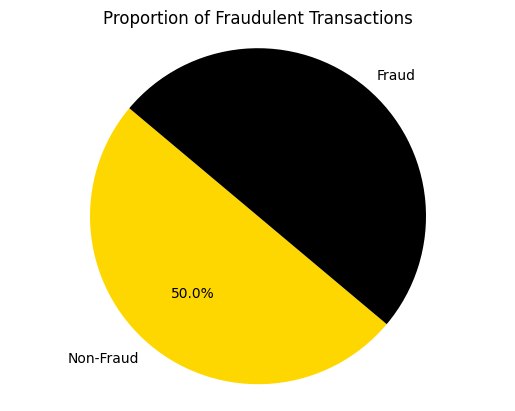

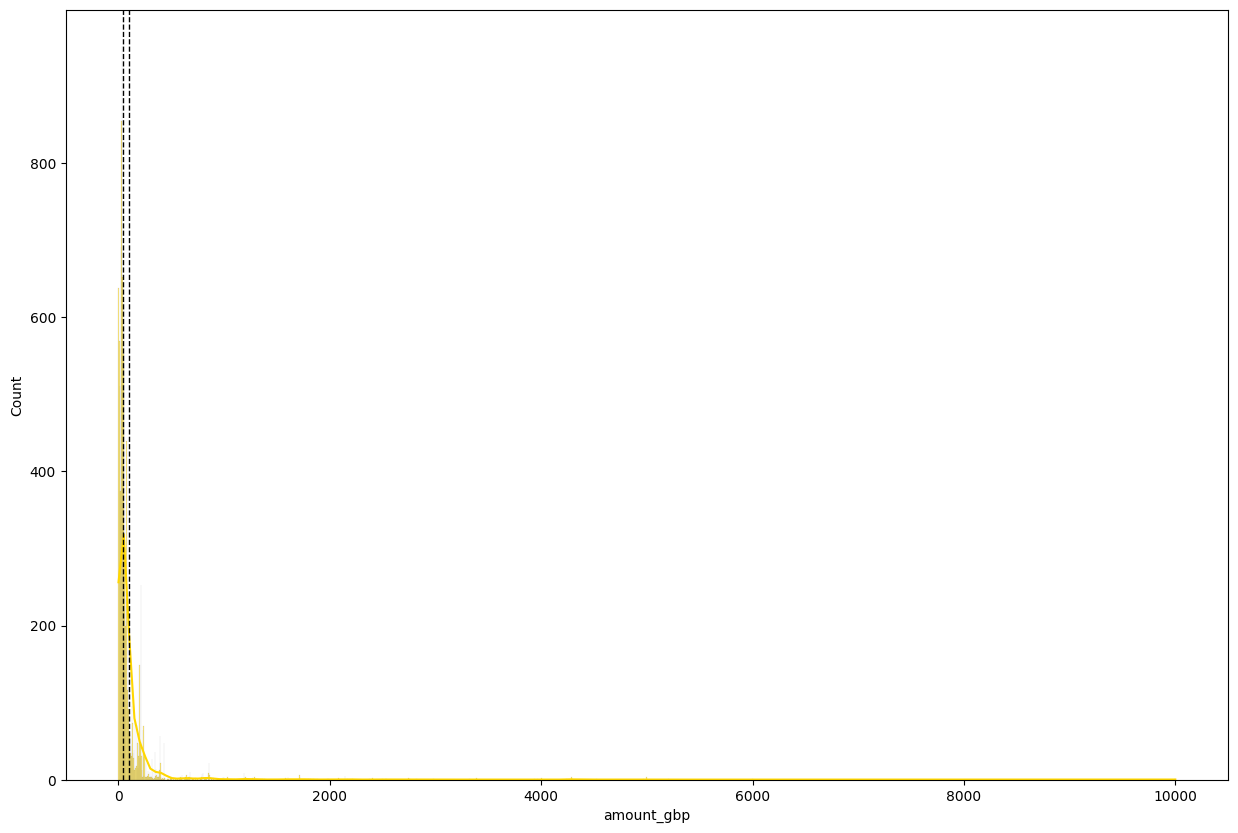

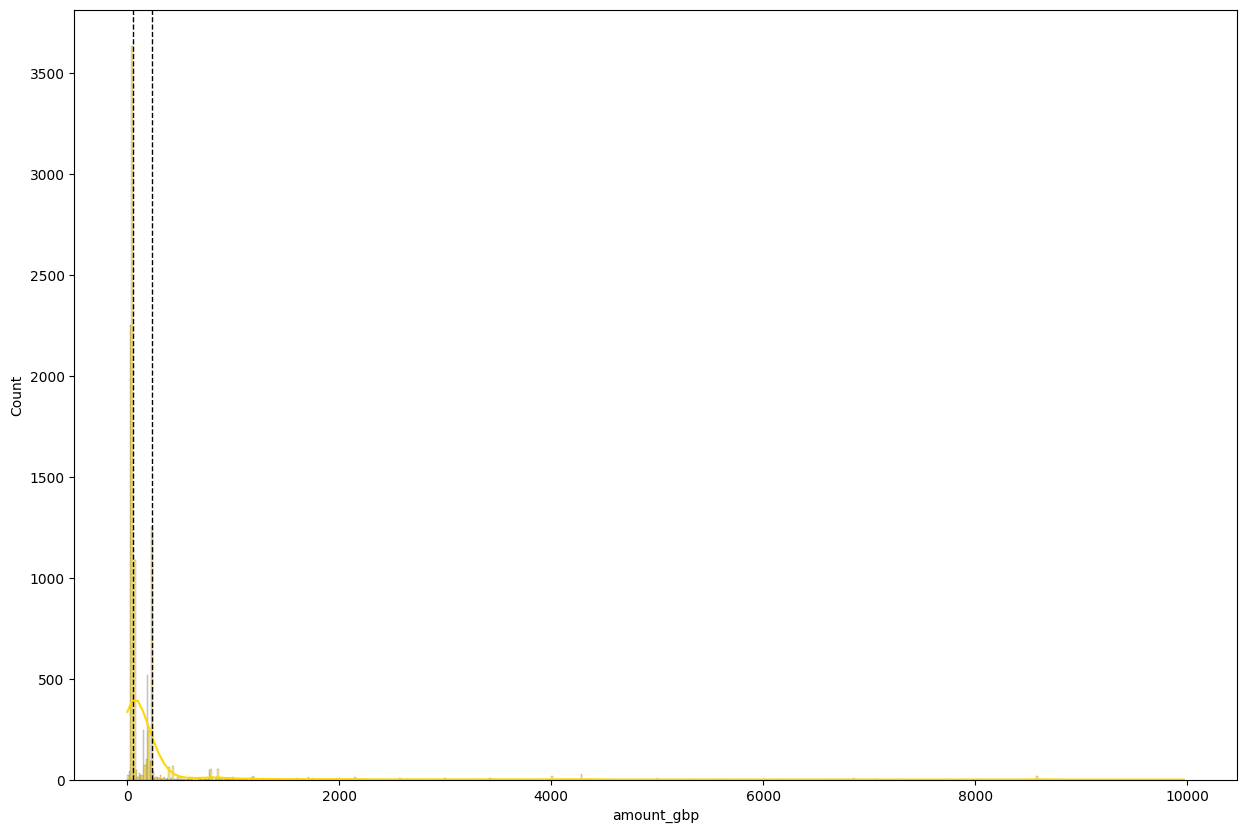

In [35]:
#Look into share of fradulent trx vs non-fraudulent
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check Amount distribution of Fraudulent Vs non Fraudulent Trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Trx_amount_gbp
plt.figure(figsize=(15,10))
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()


plt.figure(figsize=(15,10))
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()

#Generate Customer Profiles (Cust_Profiles)

In [48]:
#Calcualte Customer Profile Statistics
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']


#Calcualte Average Number of Trx
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge Datasets to one
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')

#Cust_Profiles_Data
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058555,53.65,53.65,1.0
1,1058557,53.65,53.65,1.0
2,1058558,157.75,157.75,1.0
3,1058568,157.75,157.75,1.0
4,1058569,157.75,157.75,1.0
...,...,...,...,...
19867,4642294,28.57,28.57,1.0
19868,4642454,82.59,82.59,1.0
19869,4642463,75.26,75.26,1.0
19870,4642904,21.48,21.48,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [49]:
def get_country(ip):
    # mmdb_file_path = '/content/drive/MyDrive/.../GeoLite2-City.mmdb' #Maayan's source
    mmdb_file_path = '/content/drive/MyDrive/Colab_Notebooks/CAS_Final_Project/GeoLite2-City.mmdb' #Viki's source

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return 0, 0
    else:
        return 0, 0

#df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/.../Country_lan_lat.csv",sep=';') #Maayan's source
df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CAS_Final_Project/Country_lan_lat.csv",sep=';') #Viki's source

In [50]:
#Get Customer Device IP Coordinates (Country)
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]

old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

             id  client_id  latitude_ip  longitude_ip
0       1983485    1058555          NaN           NaN
1       1983490    1058557          NaN           NaN
2       1983500       <NA>          NaN           NaN
3       1983522    1058568          NaN           NaN
4       1983524    1058569          NaN           NaN
...         ...        ...          ...           ...
21711  11588061    4642454    41.871940     12.567380
21712  11588110    4642463    46.227638      2.213749
21713  11588502    4578088    -0.023559     37.906193
21714  11589115    4642904    55.378051     -3.435973
21715  11589375    4643003    55.378051     -3.435973

[21716 rows x 4 columns]


In [52]:
#Get Customer Card Issuer Bank Coordinates (Country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()
Card_Info_Country_Profile = Card_Info_Country_Profile.fillna(0)
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile

,id,client_id,latitude_card,longitude_card
0,1983485,1058555,NaN,NaN
1,1983490,1058557,NaN,NaN
2,1983500,0,NaN,NaN
3,1983522,1058568,NaN,NaN
4,1983524,1058569,NaN,NaN
...,...,...,...,...
21711,11588061,4642454,41.871940,12.567380
21712,11588110,4642463,46.227638,2.213749
21713,11588502,4578088,-0.023559,37.906193
21714,11589115,4642904,55.378051,-3.435973


In [54]:
#Customer Country Coordinates (Final)
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,on='id')

merge_df.columns
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns

old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
Cust_Country_Profile

,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
id,,,,,
1983485,1058555,NaN,NaN,NaN,NaN
1983490,1058557,NaN,NaN,NaN,NaN
1983500,<NA>,NaN,NaN,NaN,NaN
1983522,1058568,NaN,NaN,NaN,NaN
1983524,1058569,NaN,NaN,NaN,NaN
...,...,...,...,...,...
11588061,4642454,41.871940,12.567380,41.871940,12.567380
11588110,4642463,46.227638,2.213749,46.227638,2.213749
11588502,4578088,-0.023559,37.906193,-0.023559,37.906193


# Get Transaction Profile (Trx_Profile)

In [55]:
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def is_weekend(date):
    return date.weekday() >= 5

def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

target_time = pd.to_datetime('22:00:00').time()
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['time'] > target_time).astype(int)


columns_to_drop = ['time','date']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}

Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
1983485,2021-01-01 00:01:07+00:00,1058555,53.65,67,0,0
1983490,2021-01-01 00:08:21+00:00,1058557,53.65,501,0,0
1983500,2021-01-01 00:20:30+00:00,<NA>,61.66,1230,0,0
1983522,2021-01-01 00:37:17+00:00,1058568,157.75,2237,0,0
1983524,2021-01-01 00:38:50+00:00,1058569,157.75,2330,0,0
...,...,...,...,...,...,...
11588061,2024-04-30 18:15:33+00:00,4642454,82.59,65733,0,0
11588110,2024-04-30 18:23:25+00:00,4642463,75.26,66205,0,0
11588502,2024-04-30 19:19:27+00:00,4578088,23.22,69567,0,0


# Get Customer Behavoiur Profile (Trx_Profile_Rolling)

In [56]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 1min 54s, sys: 1.9 s, total: 1min 56s
Wall time: 1min 58s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1983485,2021-01-01 00:01:07,1058555,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983490,2021-01-01 00:08:21,1058557,53.65,1.0,53.65,1.0,53.65,1.0,53.65
2006281,2021-01-05 10:54:33,1058558,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983522,2021-01-01 00:37:17,1058568,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983524,2021-01-01 00:38:50,1058569,157.75,1.0,157.75,1.0,157.75,1.0,157.75
...,...,...,...,...,...,...,...,...,...
11587707,2024-04-30 17:20:41,4642294,28.57,1.0,28.57,1.0,28.57,1.0,28.57
11588061,2024-04-30 18:15:33,4642454,82.59,1.0,82.59,1.0,82.59,1.0,82.59
11588110,2024-04-30 18:23:25,4642463,75.26,1.0,75.26,1.0,75.26,1.0,75.26


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [57]:
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].astype(bool)
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

Brand_Fraud_Profile.set_index('id')

Brand_Fraud_Profile

Brand_Fraud_Profile.set_index('id',inplace=True)

Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

Brand_Fraud_Profile

CPU times: user 1.43 s, sys: 11.6 ms, total: 1.44 s
Wall time: 1.44 s


,timestamp,Brands_id,amount_gbp_fraud_trx,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,,
1983976,2021-01-01 09:09:44,1234,37.64,1.0,37.64,1.0,37.640000,1.0,37.640000
1989686,2021-01-02 18:18:00,1234,53.65,1.0,53.65,2.0,45.645000,2.0,45.645000
1999498,2021-01-04 21:42:57,1234,157.75,1.0,157.75,3.0,83.013333,3.0,83.013333
2103691,2021-01-06 21:50:25,1234,45.64,1.0,45.64,4.0,73.670000,4.0,73.670000
2121615,2021-01-09 07:47:44,1234,53.65,1.0,53.65,4.0,77.672500,5.0,69.666000
...,...,...,...,...,...,...,...,...,...
11488955,2024-04-19 09:10:30,851558,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11554595,2024-04-26 16:44:13,851560,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11407420,2024-04-10 17:46:54,851563,NaN,0.0,NaN,0.0,NaN,0.0,NaN


# Get All Dummy Variables (Data_Dummies)

In [58]:
# creating a copy of the original data frame and adding a few columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating all dummy variables
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_RUB,Currency_name_USD,Currency_name_ZAR,Environments_name_PrestaShop,Environments_name_WooCommerce,...,Companies_name_Zofigi_Corporation_Ltd,Companies_name_Zorafin_Investments_Ltd,Companies_name_xShop_OU,Processors_name_CCD,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
1983485,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1983490,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1983500,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1983522,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1983524,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11588061,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
11588110,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
11588502,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Combine Everything to a Single Dataset

In [ ]:
# Rest indexs in all dataframes in preparation to merge
Cust_Profiles #Key is Client id
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id
Data_Dummies = Data_Dummies.reset_index(level='id') #Key is id

#Merge all datasets to a single dataset
DF_Flag = Data_Adf[['id', 'Is_fraud']]
DF_Flag['id'] = DF_Flag['id'].astype(int)
DF = pd.merge(Cust_Country_Profile, DF_Flag, how='left', on='id')
DF['Is_fraud'] = DF['Is_fraud'].astype(int)
DF1 = pd.merge(DF, Trx_Profile, how='left', on='id')
DF2 = pd.merge(DF1, Trx_Profile_Rolling,how='left',on='id')
DF3 = pd.merge(DF2, Brand_Fraud_Profile,how='left',on='id')
DF4 = pd.merge(DF3, Data_Dummies, how='left', on='id')
DF5 = pd.merge(DF4, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

#Gather columns containing ID's and other unnecessary columns to drop and drop them
column_ids = [col for col in DF5.columns if '_id' in col]
column_timestamp = [col for col in DF5.columns if 'timestamp' in col]
columns_amount = [col for col in DF5.columns if 'amount' in col]
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

DF_ready = DF5.drop(columns = dropcolumns)
DF_ready

# Extract Target Variable



In [76]:
# Extract target variable and drop unnecessary columns
y = DF_ready['Is_fraud']
X = DF_ready.drop(columns=['Is_fraud'])

# Replace NaN with zeroes
X = X.fillna(0)

X

,latitude_ip,longitude_ip,latitude_card,longitude_card,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,...,Processors_name_CCD,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,0.000000,0.000000,0.000000,0.000000,67,0,0,53.65,1.0,53.65,...,1,0,0,0,0,0,0,53.65,53.65,1.0
1,0.000000,0.000000,0.000000,0.000000,501,0,0,53.65,1.0,53.65,...,0,0,0,0,0,0,1,53.65,53.65,1.0
2,0.000000,0.000000,0.000000,0.000000,1230,0,0,0.00,0.0,0.00,...,0,0,0,0,0,0,1,0.00,0.00,0.0
3,0.000000,0.000000,0.000000,0.000000,2237,0,0,157.75,1.0,157.75,...,0,0,0,0,0,0,1,157.75,157.75,1.0
4,0.000000,0.000000,0.000000,0.000000,2330,0,0,157.75,1.0,157.75,...,0,0,0,0,0,0,1,157.75,157.75,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21711,41.871940,12.567380,41.871940,12.567380,65733,0,0,82.59,1.0,82.59,...,0,0,0,0,1,0,0,82.59,82.59,1.0
21712,46.227638,2.213749,46.227638,2.213749,66205,0,0,75.26,1.0,75.26,...,0,0,0,0,0,1,0,75.26,75.26,1.0
21713,-0.023559,37.906193,-0.023559,37.906193,69567,0,0,23.22,1.0,23.22,...,0,0,0,0,1,0,0,23.22,23.22,1.0
21714,55.378051,-3.435973,55.378051,-3.435973,74911,0,0,21.48,1.0,21.48,...,0,0,0,0,1,0,0,21.48,21.48,1.0


# Logistic Regression Model

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Random Forest Model

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a machine learning model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Neural Network Model

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test_pca)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))